In [15]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import shap
from sklearn.preprocessing import StandardScaler

In [16]:
# Load the dataset
data = pd.read_csv('C:/Users/user/Desktop/Graduate Applications/Flood Data/Flood_Data1.csv')

# Inspect the first few rows
print(data.head())

   YEAR  STATE  FLOOD OCCURENCE     RH  MAX_TEMP  MIN_TEMP  PRECIPITATION
0  1990  BENUE                0  77.38     35.99     14.08        1165.43
1  1990    FCT                0  74.44     38.61     13.43        1270.90
2  1990   KOGI                0  77.50     36.12     16.42         949.22
3  1990  KWARA                0  68.44     39.73     15.85         849.02
4  1990   NASS                0  74.12     38.76     14.87        1244.53


In [17]:
# Define the features (X) and target (y)
X = data.drop(columns=['FLOOD OCCURENCE'])  # All independent variables
y = data['FLOOD OCCURENCE']  # Dependent variable

# If 'State' is categorical, you need to encode it
X = pd.get_dummies(X, columns=['STATE'], drop_first=True)

# Check the processed data
print(X.head())

   YEAR     RH  MAX_TEMP  MIN_TEMP  PRECIPITATION  STATE_FCT  STATE_KOGI  \
0  1990  77.38     35.99     14.08        1165.43      False       False   
1  1990  74.44     38.61     13.43        1270.90       True       False   
2  1990  77.50     36.12     16.42         949.22      False        True   
3  1990  68.44     39.73     15.85         849.02      False       False   
4  1990  74.12     38.76     14.87        1244.53      False       False   

   STATE_KWARA  STATE_NASS  STATE_NIGER  STATE_PLATEAU  
0        False       False        False          False  
1        False       False        False          False  
2        False       False        False          False  
3         True       False        False          False  
4        False        True        False          False  


In [18]:
#Spliting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

#Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)#

# Initialize the MLPClassifier (ANN)
ann_clf = MLPClassifier(random_state=42, max_iter=1000)

# Define the hyperparameters and their respective values to be tested
param_grid = {
    'hidden_layer_sizes': [(50,50), (100,), (100, 50), (150, 100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=ann_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy: {:.2f}".format(test_accuracy))

Best parameters found:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'sgd'}
Best cross-validation accuracy: 0.82
Test accuracy: 0.86


In [24]:
# Predict on the test data
y_pred = best_model.predict(X_test)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Print the results
print(f"MAPE: {mape:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

MAPE: 0.1429
MSE: 0.1429
R²: -0.1667
RMSE: 0.3780


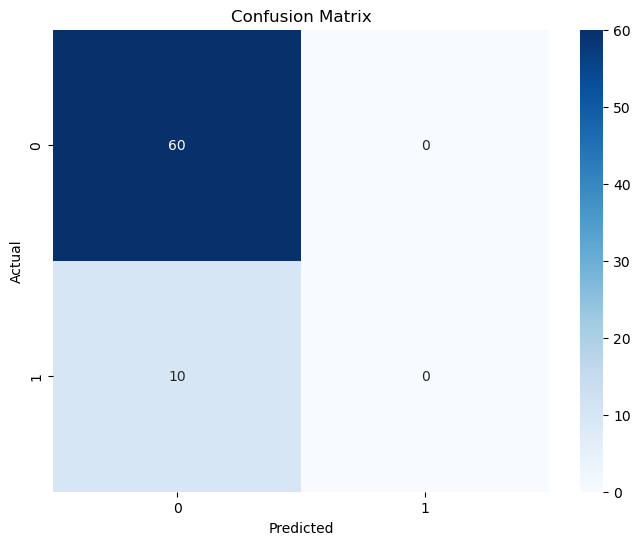

In [26]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Graduate Applications/Manuscripts/Flood prediction/image3', dpi=200)
plt.show()

In [21]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 85.71%


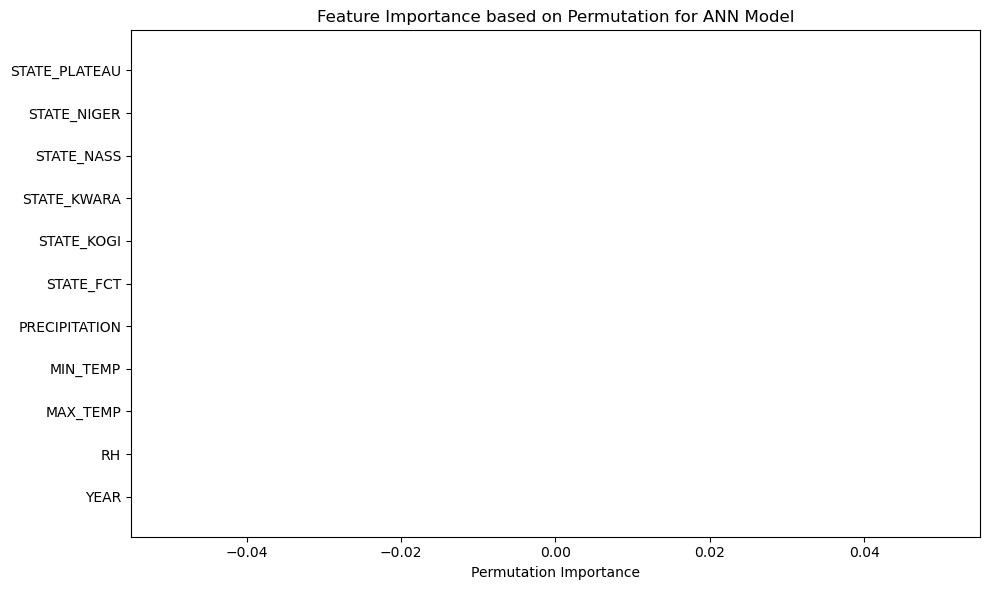

In [23]:
# Plot feature importances

from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

def compute_accuracy(X, y):
    y_pred = best_model.predict(X)
    y_pred_class = (y_pred > 0.5).astype(int).flatten()
    return accuracy_score(y, y_pred_class)

# Calculate baseline accuracy
baseline_accuracy = compute_accuracy(X_test, y_test)

# Initialize permutation importance array
importances = np.zeros(X.shape[1])
importances_std = np.zeros(X.shape[1])

# Calculate permutation importance for each feature
for i in range(X.shape[1]):
    X_permuted = X_test.copy()
    X_permuted[:, i] = shuffle(X_permuted[:, i], random_state=50)
    permuted_accuracy = compute_accuracy(X_permuted, y_test)
    importances[i] = baseline_accuracy - permuted_accuracy

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel("Permutation Importance")
plt.title("Feature Importance based on Permutation for ANN Model")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

# Compute metrics
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² (Goodness of Fit): {r2:.2f}")

In [ ]:
def safe_mean_absolute_percentage_error(y_true, y_pred):
    """Compute MAPE while handling zero values in y_true"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    nonzero_elements = y_true != 0
    if np.any(nonzero_elements):
        return np.mean(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements])) * 100
    else:
        return np.nan  # Return NaN if all y_true values are zero

# Assuming you have the trained models and X_test, y_test
def compute_metrics(y_true, y_pred):
    mape = safe_mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mape, rmse, mae, r2

# For each model:
def print_metrics(model_name, y_true, y_pred):
    mape, rmse, mae, r2 = compute_metrics(y_true, y_pred)
    print(f"{model_name} Model Metrics:")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² (Goodness of Fit): {r2:.2f}\n")

# Example for AdaBoost model (repeat similarly for other models)
y_pred = model.predict(X_test)
print_metrics("ANN", y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot Sensitivity (TPR) vs. (1 - Specificity)
plt.figure(figsize=(10, 7))
plt.plot(thresholds, tpr, color='blue', label='Sensitivity')
plt.plot(thresholds, 1-fpr, color='red', label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Sensitivity and Specificity vs. Threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='blue', label='Precision-Recall curve')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [ ]:
# Assume y_true and y_pred are your true labels and predicted labels respectively
#conf_matrix = confusion_matrix(y_test, y_pred)

# Extract True Positives (TP) and False Negatives (FN)
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]

# Calculate Sensitivity
sensitivity = TP / (TP + FN)
print(f"Sensitivity: {sensitivity:.2f}")